# Gravity segregation example
The simplest type of porous media simulation problem to set up that is not
trivial is the transition to equilibrium from an unstable initial condition.
Placing a heavy fluid on top of a lighter fluid will lead to the heavy fluid
moving down while the lighter fluid moves up.

## Problem set up
We define a simple 1D gravity column with an approximate 10-1 ratio in density
between the two compressible phases and let it simulate until equilibrium is
reached.

In [1]:
using JutulDarcy, Jutul
nc = 100
Darcy, bar, kg, meter, day = si_units(:darcy, :bar, :kilogram, :meter, :day)

g = CartesianMesh((1, 1, nc), (1.0, 1.0, 10.0))
domain = reservoir_domain(g, permeability = 1.0*Darcy)

DataDomain wrapping CartesianMesh (3D) with 1x1x100=100 cells with 17 data fields added:
  100 Cells
    :permeability => 100 Vector{Float64}
    :porosity => 100 Vector{Float64}
    :rock_thermal_conductivity => 100 Vector{Float64}
    :fluid_thermal_conductivity => 100 Vector{Float64}
    :rock_density => 100 Vector{Float64}
    :cell_centroids => 3×100 Matrix{Float64}
    :volumes => 100 Vector{Float64}
  99 Faces
    :neighbors => 2×99 Matrix{Int64}
    :areas => 99 Vector{Float64}
    :normals => 3×99 Matrix{Float64}
    :face_centroids => 3×99 Matrix{Float64}
  198 HalfFaces
    :half_face_cells => 198 Vector{Int64}
    :half_face_faces => 198 Vector{Int64}
  402 BoundaryFaces
    :boundary_areas => 402 Vector{Float64}
    :boundary_centroids => 3×402 Matrix{Float64}
    :boundary_normals => 3×402 Matrix{Float64}
    :boundary_neighbors => 402 Vector{Int64}


## Fluid properties
Define two phases liquid and vapor with a 10-1 ratio reference densities and
set up the simulation model.

In [2]:
p0 = 100*bar

rhoLS = 1000.0*kg/meter^3
rhoVS = 100.0*kg/meter^3
cl, cv = 1e-5/bar, 1e-4/bar
L, V = LiquidPhase(), VaporPhase()
sys = ImmiscibleSystem([L, V])
model = SimulationModel(domain, sys)

SimulationModel:

  Model with 200 degrees of freedom, 200 equations and 498 parameters

  domain:
    DiscretizedDomain with MinimalTPFATopology (100 cells, 99 faces) and discretizations for mass_flow, heat_flow

  system:
    ImmiscibleSystem with LiquidPhase, VaporPhase

  context:
    DefaultContext(EquationMajorLayout(false), 9223372036854775807, 1)

  formulation:
    FullyImplicitFormulation()

  data_domain:
    DataDomain wrapping CartesianMesh (3D) with 1x1x100=100 cells with 17 data fields added:
  100 Cells
    :permeability => 100 Vector{Float64}
    :porosity => 100 Vector{Float64}
    :rock_thermal_conductivity => 100 Vector{Float64}
    :fluid_thermal_conductivity => 100 Vector{Float64}
    :rock_density => 100 Vector{Float64}
    :cell_centroids => 3×100 Matrix{Float64}
    :volumes => 100 Vector{Float64}
  99 Faces
    :neighbors => 2×99 Matrix{Int64}
    :areas => 99 Vector{Float64}
    :normals => 3×99 Matrix{Float64}
    :face_centroids => 3×99 Matrix{Float64}
  19

### Definition for phase mass densities
Replace default density with a constant compressibility function that uses the
reference values at the initial pressure.

In [3]:
density = ConstantCompressibilityDensities(sys, p0, [rhoLS, rhoVS], [cl, cv])
set_secondary_variables!(model, PhaseMassDensities = density)

### Set up initial state
Put heavy phase on top and light phase on bottom. Saturations have one value
per phase, per cell and consequently a per-cell instantiation will require a
two by number of cells matrix as input.

In [4]:
nl = nc ÷ 2
sL = vcat(ones(nl), zeros(nc - nl))'
s0 = vcat(sL, 1 .- sL)
state0 = setup_state(model, Pressure = p0, Saturations = s0)

Dict{Symbol, Any} with 7 entries:
  :PhaseMassMobilities    => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
  :PhaseMassDensities     => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
  :RelativePermeabilities => [0.5 0.5 … 0.5 0.5; 0.5 0.5 … 0.5 0.5]
  :Saturations            => [1.0 1.0 … 0.0 0.0; 0.0 0.0 … 1.0 1.0]
  :Pressure               => [1.0e7, 1.0e7, 1.0e7, 1.0e7, 1.0e7, 1.0e7, 1.0e7, …
  :TotalMasses            => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
  :PhaseMobilities        => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

Convert time-steps from days to seconds

In [5]:
timesteps = repeat([0.02]*day, 150)

150-element Vector{Float64}:
 1728.0
 1728.0
 1728.0
 1728.0
 1728.0
 1728.0
 1728.0
 1728.0
 1728.0
 1728.0
    ⋮
 1728.0
 1728.0
 1728.0
 1728.0
 1728.0
 1728.0
 1728.0
 1728.0
 1728.0

In [6]:
# Perform simulation
states, report = simulate(state0, model, timesteps, info_level = -1)

SimResult with 150 entries:

  states (model variables)
    :Saturations => Matrix{Float64} of size (2, 100)
    :Pressure => Vector{Float64} of size (100,)
    :TotalMasses => Matrix{Float64} of size (2, 100)

  reports (timing/debug information)
    :ministeps => Vector{Any} of size (1,)
    :total_time => Float64
    :output_time => Float64

  Completed at Aug. 02 2024 14:08 after 3 seconds, 707 milliseconds, 893.8 microseconds.

## Plot results
The 1D nature of the problem allows us to plot all timesteps simultaneously in
2D. We see that the heavy fluid, colored blue, is initially at the top of the
domain and the lighter fluid is at the bottom. These gradually switch places
until all the heavy fluid is at the lower part of the column.

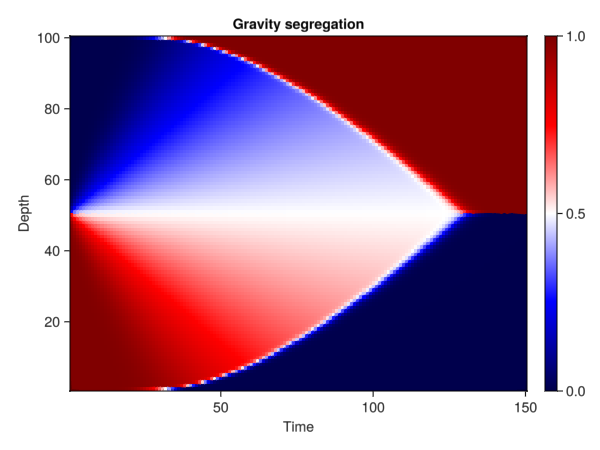

In [7]:
using GLMakie
tmp = vcat(map((x) -> x[:Saturations][1, :]', states)...)
f = Figure()
ax = Axis(f[1, 1], xlabel = "Time", ylabel = "Depth", title = "Gravity segregation")
hm = heatmap!(ax, tmp, colormap = :seismic)
Colorbar(f[1, 2], hm)
f

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*